## Import Library

In [34]:
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from nltk_utils import tokenize, stem, bag_of_words
from model import create_model
import matplotlib.pyplot as plt
from keras import layers, models
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

## Define Variables

In [35]:
PATH_INTENTS = '../../data/intents.json'
PATH_MODEL = 'chat_model.h5'
PATH_METADATA = 'metadata.json'

In [36]:
# Define lists
all_words = []  # Words in the patterns
tags = []       # Tags of sentences
xy = []         # (Pattern sentence, Tag) pairs

## Load Data

In [37]:
# Open file json
with open(PATH_INTENTS, 'r') as f:
    intents = json.load(f)

## Data Preparation

In [38]:
# # Process each intent
# for intent in intents['intents']:
#     tag = intent['tag']
#     tags.append(tag)
#     for pattern in intent['patterns']:
#         w = tokenize(pattern)
#         all_words.extend(w)
#         xy.append((w, tag))

In [39]:
# Process each intent
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        xy.append((pattern, tag))
        all_words.append(pattern)

In [40]:
xy[:5]

[('Hi', 'greeting'),
 ('Hey', 'greeting'),
 ('Is anyone there?', 'greeting'),
 ('Hi there', 'greeting'),
 ('Hello', 'greeting')]

In [41]:
# Stemming
ignore_words = ['?', '!', '.', ',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
# all_words = sorted(set(all_words))
# tags = sorted(set(tags))

In [42]:
tags = sorted(set(tags))
tag_to_index = {tag: idx for idx, tag in enumerate(tags)}

In [43]:
tag_to_index

{'about': 0,
 'afternoon': 1,
 'anxious': 2,
 'ask': 3,
 'casual': 4,
 'creation': 5,
 'death': 6,
 'default': 7,
 'depressed': 8,
 'done': 9,
 'evening': 10,
 'fact-1': 11,
 'fact-10': 12,
 'fact-11': 13,
 'fact-12': 14,
 'fact-13': 15,
 'fact-14': 16,
 'fact-15': 17,
 'fact-16': 18,
 'fact-17': 19,
 'fact-18': 20,
 'fact-19': 21,
 'fact-2': 22,
 'fact-20': 23,
 'fact-21': 24,
 'fact-22': 25,
 'fact-23': 26,
 'fact-24': 27,
 'fact-25': 28,
 'fact-26': 29,
 'fact-27': 30,
 'fact-28': 31,
 'fact-29': 32,
 'fact-3': 33,
 'fact-30': 34,
 'fact-31': 35,
 'fact-32': 36,
 'fact-5': 37,
 'fact-6': 38,
 'fact-7': 39,
 'fact-8': 40,
 'fact-9': 41,
 'friends': 42,
 'goodbye': 43,
 'greeting': 44,
 'happy': 45,
 'hate-me': 46,
 'hate-you': 47,
 'help': 48,
 'jokes': 49,
 'learn-mental-health': 50,
 'learn-more': 51,
 'location': 52,
 'meditation': 53,
 'mental-health-fact': 54,
 'morning': 55,
 'name': 56,
 'neutral-response': 57,
 'night': 58,
 'no-approach': 59,
 'no-response': 60,
 'not-talkin

In [44]:
tags

['about',
 'afternoon',
 'anxious',
 'ask',
 'casual',
 'creation',
 'death',
 'default',
 'depressed',
 'done',
 'evening',
 'fact-1',
 'fact-10',
 'fact-11',
 'fact-12',
 'fact-13',
 'fact-14',
 'fact-15',
 'fact-16',
 'fact-17',
 'fact-18',
 'fact-19',
 'fact-2',
 'fact-20',
 'fact-21',
 'fact-22',
 'fact-23',
 'fact-24',
 'fact-25',
 'fact-26',
 'fact-27',
 'fact-28',
 'fact-29',
 'fact-3',
 'fact-30',
 'fact-31',
 'fact-32',
 'fact-5',
 'fact-6',
 'fact-7',
 'fact-8',
 'fact-9',
 'friends',
 'goodbye',
 'greeting',
 'happy',
 'hate-me',
 'hate-you',
 'help',
 'jokes',
 'learn-mental-health',
 'learn-more',
 'location',
 'meditation',
 'mental-health-fact',
 'morning',
 'name',
 'neutral-response',
 'night',
 'no-approach',
 'no-response',
 'not-talking',
 'pandora-useful',
 'problem',
 'repeat',
 'sad',
 'scared',
 'skill',
 'sleep',
 'something-else',
 'stressed',
 'stupid',
 'suicide',
 'thanks',
 'understand',
 'user-advice',
 'user-agree',
 'user-meditation',
 'worthless',
 'w

In [45]:
all_words[-5:]

["how do i know if i'm unwell?",
 'how can i maintain social connections? what if i feel lonely?',
 "what's the difference between anxiety and stress?",
 "what's the difference between sadness and depression?",
 'difference between sadness and depress']

In [46]:
tags[:5]

['about', 'afternoon', 'anxious', 'ask', 'casual']

In [47]:
# # Create training data
# x_train = []
# y_train = []
# for (pattern_sentence, tag) in xy:
#     bag = bag_of_words(pattern_sentence, all_words)
#     x_train.append(bag)
#     y_train.append(tag)

In [48]:
# Melakukan vektorisasi untuk mengekstrak fitur dengan TF-IDF
vectorizer = TfidfVectorizer(tokenizer=tokenize,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [49]:
# Create TF-IDF vectorizer and transform the corpus
# vectorizer = TfidfVectorizer(tokenizer=tokenize)
x_train = vectorizer.fit_transform(all_words).toarray()
y_train = np.array([tag_to_index[tag] for _, tag in xy])

d:\Coding\Projects\HearMePal\env\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [50]:
# Convert to numpy arrays
x_train = np.array(x_train)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(tags))

In [51]:
# Mengubah ukuran data menjadi ukuran yang diterima oleh LTSM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [52]:
x_train.shape

(232, 50, 1)

## Modeling

In [53]:
# Define hyperparameters
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)
learning_rate = 0.001
num_epochs = 100
batch_size = 8

In [54]:
output_size

80

In [55]:
# Create the model
# model = models.Sequential()
# model.add(layers.Input(shape=(input_size,)))
# model.add(layers.Dense(64))
# model.add(layers.Dense(32))
# model.add(layers.Dense(16))
# model.add(layers.Dense(hidden_size))
# model.add(layers.Dense(output_size, activation='softmax'))

In [56]:
len(xy)

232

In [57]:
input_size

50

In [58]:
x_train.shape

(232, 50, 1)

In [59]:
y_train.shape

(232, 80)

In [60]:
model = Sequential()
model.add(layers.Input(shape=(input_size,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(output_size, activation="softmax"))

In [61]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
# Train the model
# model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_split=0.3)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.0251 - loss: 4.6392 - val_accuracy: 0.0000e+00 - val_loss: 5.7952
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.0470 - loss: 3.8936 - val_accuracy: 0.0000e+00 - val_loss: 6.5493
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.0540 - loss: 3.6044 - val_accuracy: 0.0000e+00 - val_loss: 7.0727
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.0579 - loss: 3.3713 - val_accuracy: 0.0000e+00 - val_loss: 7.3898
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.0801 - loss: 3.2723 - val_accuracy: 0.0000e+00 - val_loss: 7.3975
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.0781 - loss: 3.3025 - val_accuracy: 0.0000e+00 - val_loss: 7.7377
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.1481 - loss: 3.1985 - val_accuracy: 0.0000e+00 - val_loss: 7.4145
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.1428 -

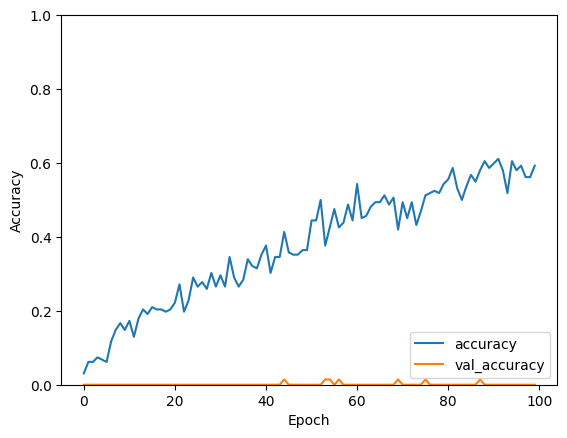

In [63]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Export

In [64]:
# # Save model and metadata
# model.save(PATH_MODEL)
# metadata = {
#     'input_size': input_size,
#     'output_size': output_size,
#     'hidden_size': hidden_size,
#     'all_words': all_words,
#     'tags': tags,
#     'label_encoder_classes': label_encoder.classes_.tolist()
# }

# with open(PATH_METADATA, 'w') as f:
#     json.dump(metadata, f)
# print('Training complete. Model and metadata saved.')

In [65]:
# Save model and metadata
model.save(PATH_MODEL)
metadata = {
    'input_size': input_size,
    'output_size': output_size,
    'hidden_size': hidden_size,
    'all_words': all_words,
    'tags': tags,
    'vectorizer_vocabulary': vectorizer.vocabulary_,
    'label_encoder_classes': label_encoder.classes_.tolist()
}

with open(PATH_METADATA, 'w') as f:
    json.dump(metadata, f)
print('Training complete. Model and metadata saved.')

Training complete. Model and metadata saved.


In [67]:

import joblib

# Save the vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']